<a href="https://colab.research.google.com/github/daylightzjr/daylightzjr/blob/main/CNN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
print(torch.__version__)
print(torchvision.__version__)

2.4.0+cu121
0.19.0+cu121


In [36]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##数据集的加载和划分

In [37]:
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [38]:
len(train_data), len(test_data)

(60000, 10000)

In [39]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [40]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [41]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [42]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)
test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

##Building a Convolutional Neural Network(CNN)

In [43]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
              out_channels=hidden_units,
              kernel_size=3,
              padding = 1,
              stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
              out_channels=hidden_units,
              kernel_size=3,
              padding=1,
              stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
              out_features=output_shape)
    )
  def forward(self,x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [44]:
model_2 = FashionMNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

##Build optimizer loss and evaluation

In [45]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download...


In [46]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.1)

##Setup the function of training and evaluation/testing loops

In [47]:
def train_step(model:torch.nn.Module,
        data_loader:torch.utils.data.DataLoader,
        loss_fn:torch.nn.Module,
        optimizer:torch.optim.Optimizer,
        accuracy_fn,
        device = device):
  train_loss,train_acc = 0,0
  model.train()
  for batch ,(X,y) in enumerate(data_loader):
    X,y = X.to(device),y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [48]:
def test_step(model:torch.nn.Module,
        data_loader:torch.utils.data.DataLoader,
        loss_fn:torch.nn.Module,
        accuracy_fn,
        device = device):
  test_loss,test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device),y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred,y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

In [49]:
# 定义 print_train_time 函数
def print_train_time(start, end, device):
    elapsed_time = end - start
    print(f"Training time on {device}: {elapsed_time:.2f} seconds")
    return elapsed_time


In [50]:
torch.manual_seed(8)
torch.cuda.manual_seed(8)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  ### Training
  train_step(model=model_2,
        data_loader = train_dataloader,
        loss_fn = loss_fn,
        optimizer =optimizer,
        accuracy_fn = accuracy_fn,
        device=device)
  ### Testing
  test_step(model=model_2,
        data_loader = test_dataloader,
        loss_fn = loss_fn,
        accuracy_fn = accuracy_fn,
        device = device)
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                        end=train_time_end_model_2,
                        device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.61881 | Train acc: 77.44%
Test loss: 0.45050 | Test acc: 83.13%
Epoch: 1
------
Train loss: 0.38602 | Train acc: 86.19%
Test loss: 0.37406 | Test acc: 86.54%
Epoch: 2
------
Train loss: 0.35292 | Train acc: 87.20%
Test loss: 0.35144 | Test acc: 87.49%
Training time on cpu: 190.36 seconds


In [51]:
time = 0
for i , j in test_dataloader:
  time +=1
print(time)

313


##Make and evaluate random predictions with best model

In [61]:
def make_predictions(model:torch.nn.Module,
           data:list,
           device:torch.device = device):
  pred_probs=[]
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      #Prepare the sample(add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample,dim=0).to(device)
      pred_logits = model(sample)

      pred_prob = torch.softmax(pred_logits.squeeze(),dim=0)
      #Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())
  #Stack the pred_probs to turn list ito a tensor

  return torch.stack(pred_probs)

In [62]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [63]:
test_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [64]:
import random
random.seed(8)
test_samples = []
test_labels = []

for sample,label in random.sample(list(test_data),k =9):
   test_samples.append(sample)
   test_labels.append(label)

#View the first shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Pullover')

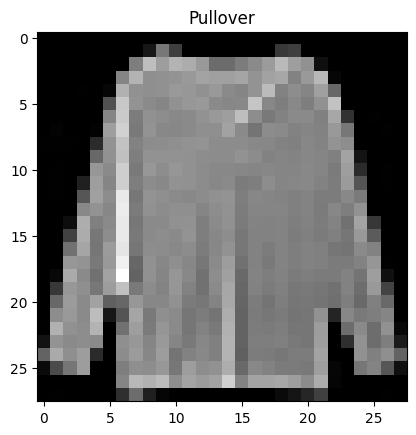

In [65]:
plt.imshow(test_samples[0].squeeze(),cmap="gray")
plt.title(class_names[test_labels[0]])

In [66]:
#Make prediction
pred_probs = make_predictions (model=model_2,
                  data= test_samples)

pred_probs[:2]

tensor([[6.4784e-02, 2.1740e-03, 4.2073e-01, 1.4233e-01, 6.4708e-03, 1.9294e-05,
         3.4711e-01, 2.6109e-05, 1.6241e-02, 1.2248e-04],
        [3.5986e-03, 2.9912e-04, 7.1568e-01, 2.0969e-04, 1.5262e-01, 1.1864e-03,
         1.2396e-01, 1.0516e-05, 2.0803e-03, 3.5814e-04]])

In [68]:
test_labels

[2, 2, 8, 6, 2, 7, 6, 7, 2]

In [69]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 2, 8, 6, 8, 7, 6, 7, 2])

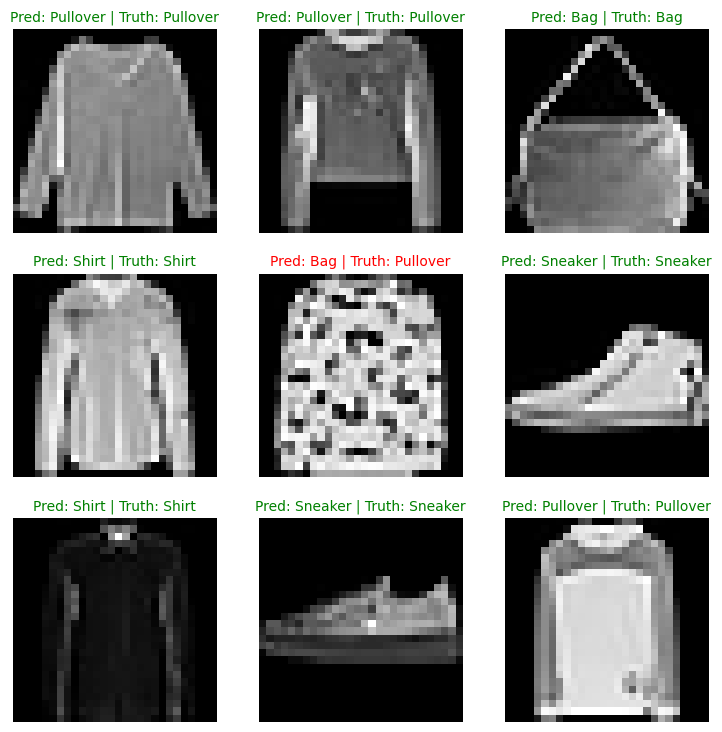

In [70]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False);

Making a confusion matrix (混淆矩阵) for further prediction evaluation

In [72]:
from tqdm.auto import tqdm
y_preds=[]
model_2.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader,desc="Making prediction..."):
    X,y = X.to(device),y.to(device)
    y_logits = model_2(X)
    y_pred = torch.softmax(y_logits.squeeze(),dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())
print(y_preds)

Making prediction...:   0%|          | 0/313 [00:00<?, ?it/s]

[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 6, 8, 0, 2, 5, 7, 5,
        1, 6, 6, 0, 9, 3, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 3, 9, 6, 7, 2, 3, 2, 6, 4, 2, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5]), tensor([1, 3, 3, 3, 7, 8, 7, 6, 2, 6, 4, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
        0, 6, 5, 3, 6, 7, 1, 6]), tensor([6, 1, 4, 2, 3, 6, 7, 6, 7, 8, 8, 9, 9, 4, 2, 5, 7, 6, 5, 2, 8, 4, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4]), tensor([1, 5, 4, 1, 9, 1, 8, 6, 6, 1, 2, 5, 1, 6, 0, 0, 1, 6, 1, 3, 2, 2, 8, 8,
        1, 4, 5, 6, 4, 7, 9, 3]), tensor([7, 2, 3, 8, 0, 9, 4, 7, 8, 2, 6, 5, 4, 1, 2, 8, 3, 0, 9, 1, 0, 9, 3, 6,
        7, 9, 9, 4, 4, 7, 1, 2]), tensor([0, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        1, 6, 7, 2, 8, 5, 2, 0]), tensor([7, 7, 6, 6, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 3, 2, 5, 4, 9, 2, 2, 8, 6, 4,
        6, 2, 9, 7, 3, 5, 5, 4]), tensor([8, 5, 2, 3, 0, 4, 8, 6, 0, 6, 4, 8, 9, 6, 1, 3, 6, 2, 3, 0, 8, 3, 7, 4,
       

In [74]:
y_pred_tensor  = torch.cat(y_preds)
y_pred_tensor

tensor([9, 2, 1,  ..., 0, 1, 2])

In [75]:
len(y_pred_tensor)

10000

In [76]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 10.2 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [77]:
import mlxtend
print(mlxtend.__version__)

0.23.1


In [78]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [79]:
y_pred_tensor[:10]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [80]:
test_data.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

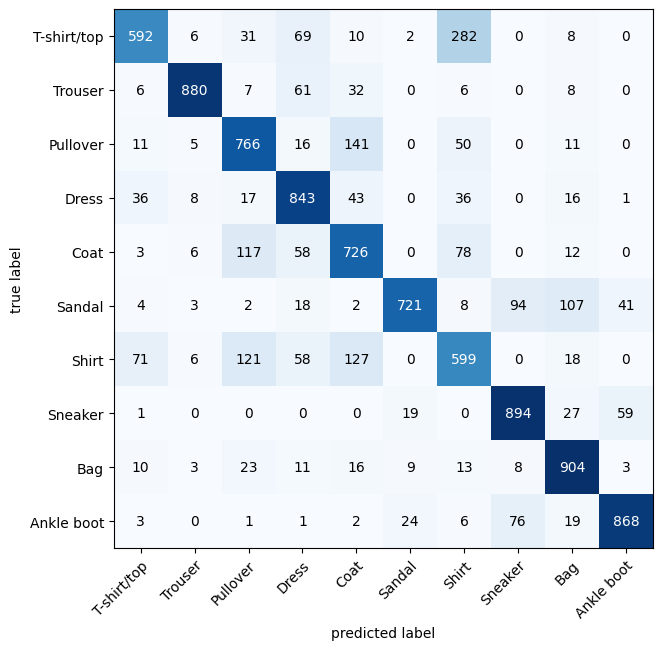

In [82]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task="multiclass",num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)

Save and load best performing model

In [83]:
from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [84]:
image_shape = [1, 28, 28]

In [85]:
# Create a new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_2.to(device)

<ipython-input-85-d3aa727c7c4d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)